# WISDM HAR - CBAM(1)

- 정적, 동적 활동을 분리하여 학습

1.  동적 활동(Dynamic Activities) 모델: 'Walking', 'Jogging', 'Upstairs', 'Downstairs'
2.  정적 활동(Static Activities) 모델: 'Sitting', 'Standing'
- layer마다 block 수를 다르게 할당


In [1]:
!pip install -q torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
def load_and_preprocess_data(file_path):
    """WISDM HAR 데이터 로드 및 전처리"""
    df = pd.read_csv(file_path)

    df['x-axis'] = df['x-axis'].astype('float32')
    df['y-axis'] = df['y-axis'].astype('float32')
    df['z-axis'] = df['z-axis'].astype('float32')

    return df

In [5]:
class WISDMDataset(Dataset):
    def __init__(self, data, window_size=128, scaler=None):
        self.window_size = window_size
        self.data = []
        self.labels = []

        self.activity_encoder = LabelEncoder()

        # sliding window
        for user in data['user'].unique():
            user_data = data[data['user'] == user]
            sensor_data = user_data[['x-axis', 'y-axis', 'z-axis']].values
            activity_labels = user_data['activity'].values

            for i in range(0, len(sensor_data) - window_size + 1, window_size // 2):
                window = sensor_data[i:i + window_size]
                labels_in_window = activity_labels[i:i + window_size]

                if len(window) == window_size:
                    # 최빈값을 label로
                    # Counter(labels_in_window).most_common(1) -> [('Walking', 120)]과 같은 형태
                    most_common_label = Counter(labels_in_window).most_common(1)[0][0]

                    self.data.append(window)
                    self.labels.append(most_common_label)

        # label encoding
        self.encoded_labels = self.activity_encoder.fit_transform(self.labels)

        # scaling
        self.data = np.array(self.data)
        original_shape = self.data.shape
        if scaler is None:
            self.scaler = StandardScaler()
            self.data = self.scaler.fit_transform(self.data.reshape(-1, 3)).reshape(original_shape) # StandardSclaer는 2차원 입력을 받음
        else:
            self.scaler = scaler
            self.data = self.scaler.transform(self.data.reshape(-1, 3)).reshape(original_shape)

        print(f"Dataset created with {len(self.data)} samples.")
        print(f"... Activity distribution: {Counter(self.labels)}\n") # Counter: 각 항목이 몇 개씩 들어 있는지 세서 딕셔너리 형태로 알려줌

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # [길이 128, 채널 3] 형태의 데이터를 [채널 3, 길이 128]로 변환
        data_tensor = torch.FloatTensor(self.data[idx]).transpose(0, 1)
        label_tensor = torch.LongTensor([self.encoded_labels[idx]])[0]
        return data_tensor, label_tensor

In [6]:
# 1D 채널 어텐션 모듈
class ChannelAttention1D(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention1D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        # 1x1 Conv를 사용한 공유 MLP 구현
        self.shared_mlp = nn.Sequential(
            nn.Conv1d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        # avg_out + max_out 후 sigmoid 적용
        attention_map = self.sigmoid(avg_out + max_out)
        # 원본 입력 x와 채널별 가중치 맵을 곱함 (브로드캐스팅)
        return x * attention_map.expand_as(x)

In [7]:
# 1D 공간 어텐션 모듈
class SpatialAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention1D, self).__init__()
        # 'same' 패딩을 위해 커널 크기는 홀수여야 함
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        padding = (kernel_size - 1) // 2

        # 채널(avg, max)을 따라 concat된 2개 채널을 1개로 줄이는 Conv
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 채널 차원으로 풀링 (dim=1)
        avg_out = torch.mean(x, dim=1, keepdim=True) # (B, 1, L)
        max_out, _ = torch.max(x, dim=1, keepdim=True) # (B, 1, L)

        # 두 맵을 채널 차원으로 연결
        concatenated = torch.cat([avg_out, max_out], dim=1) # (B, 2, L)

        # Conv 연산 및 Sigmoid
        attention_map = self.sigmoid(self.conv(concatenated)) # (B, 1, L)
        # 원본 입력 x와 공간별 가중치 맵을 곱함 (브로드캐스팅)
        return x * attention_map.expand_as(x)

In [8]:
# 1D CBAM 모듈 (채널 -> 공간 순차 적용)
class CBAM1D(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM1D, self).__init__()
        self.channel_attention = ChannelAttention1D(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention1D(kernel_size)

    def forward(self, x):
        # 채널 어텐션 적용
        x_refined = self.channel_attention(x)
        # 공간 어텐션 적용
        x_final = self.spatial_attention(x_refined)
        return x_final

In [9]:
class BasicBlock1D_CBAM(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction_ratio=16):
        super(BasicBlock1D_CBAM, self).__init__()

        # 3x1 합성곱 -> 배치 정규화 -> ReLU
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        # 3x1 합성곱 -> 배치 정규화
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # 잔차 연결 직전에 CBAM 적용
        self.cbam = CBAM1D(out_channels, reduction_ratio)

        # Shortcut 경로 (Stride가 1이 아니거나 입력/출력 채널 수가 다를 때 차원 맞춰주기)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        out += shortcut
        out = self.relu(out)
        return out

블록 수를 다르게 쌓는 이유
- ResNet 설계에 따름
- 초기 레이어는 시퀀스 길이가 길고 채널 수가 적으며, 기본적인 특징을 학습
- 후기 레이어는 시퀀스 길이는 짧아지지만 채널 수가 많아짐, 복잡하고 추상적인 특징을 학습
- 복잡한 특징을 배워야 하는 후기 레이어에 블록을 더 많이 쌓는 것이 모델 성능 향상에 효율적


In [10]:
class ResNet1D_CBAM(nn.Module):
    def __init__(self, block, num_blocks_list, num_classes, input_channels=3):
        super(ResNet1D_CBAM, self).__init__()
        self.in_channels = 64 # Stem 통과 후 채널 수

        # Stem
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False), # [B, 64, 64]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1) # [B, 64, 32]
        )

        # ResNet 레이어 생성
        self.layer1 = self._make_layer(block, 64, num_blocks_list[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks_list[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks_list[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks_list[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 첫 번째 블록에서만 stride를 적용하여 다운샘플링
        strides = [stride] + [1] * (num_blocks - 1) # e.g., [2, 1, 1, 1]
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

In [11]:
def train_model(model, train_loader, val_loader, num_epochs, model_save_path, class_weights=None, patience=10):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5) # 손실이 개선되지 않으면 학습률을 낮춤

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf') # 가장 좋았던 검증 손실을 저장하는 변수
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # 훈련 단계
        model.train()
        train_loss = 0.0
        correct_train, total_train = 0, 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad() # 이전 그래디언트 초기화
            outputs = model(data) # 순전파
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 그래디언트 폭주 방지를 위한 gradient clipping
            optimizer.step() # 가중치 업데이트
            train_loss += loss.item()

            # 훈련 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # 검증 단계
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        scheduler.step(avg_val_loss)

        # 최고 성능 모델 저장 (Early Stopping 기준)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path) # 지정된 경로에 모델 저장
            early_stop_counter = 0  # 카운터 초기화
        else:
            early_stop_counter += 1 # 성능이 개선되지 않으면 카운터 증가

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break # 훈련 중단

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f},  Val Accuracy: {val_accuracy:.4f}')

    return history

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [13]:
# 모델 평가
def evaluate_model(model, test_loader, dataset):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nAccuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(classification_report(all_labels, all_preds, target_names=dataset.activity_encoder.classes_, digits=4))
    plot_confusion_matrix(all_labels, all_preds, dataset.activity_encoder.classes_)

In [14]:
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(True)

    ax2.plot(history['train_acc'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='green')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(True)

    plt.show()



### `run_experiment` 함수의 역할
parameter
- `activity_type`: "Dynamic" 또는 "Static"
- `activities`: 해당 실험에 사용할 활동 목록
- `full_df`: 전체 데이터프레임
- `num_epochs`: 훈련 에포크 수

함수 동작 과정
1.  주어진 활동 목록으로 원본 데이터를 필터링
2.  피험자 ID를 기준으로 훈련/검증/테스트 데이터프레임으로 나눔
3.  데이터셋, 데이터로더 생성(스케일러 데이터 유출 방지 로직 포함)
4.  분류할 클래스 수에 맞춰 모델을 생성
5.  모델을 훈련하고, 최고 성능 모델을 저장
6.  저장된 최고 모델로 최종 평가를 수행하고, 훈련 과정을 시각화


### STARTING EXPERIMENT FOR: DYNAMIC ACTIVITIES ###
Filtered data for Dynamic activities. Total rows: 978132

Creating datasets...
Dataset created with 11642 samples.
... Activity distribution: Counter({'Walking': 5026, 'Jogging': 4007, 'Upstairs': 1464, 'Downstairs': 1145})

Dataset created with 1952 samples.
... Activity distribution: Counter({'Walking': 846, 'Jogging': 610, 'Upstairs': 276, 'Downstairs': 220})

Dataset created with 1637 samples.
... Activity distribution: Counter({'Walking': 648, 'Jogging': 631, 'Upstairs': 179, 'Downstairs': 179})

Class Weights for Dynamic: ['Downstairs' 'Jogging' 'Upstairs' 'Walking']
Calculated weights: [2.5419214  0.7263539  1.9880464  0.57908875]
Model for Dynamic created with 4 output classes.

--- Model Summary ---
Layer (type:depth-idx)                             Output Shape              Param #
ResNet1D_CBAM                                      [64, 4]                   --
├─Sequential: 1-1                                  [64, 64, 32]  

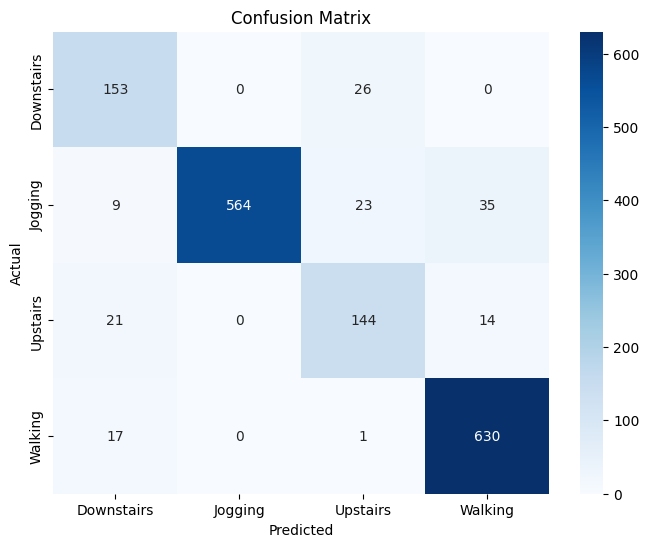

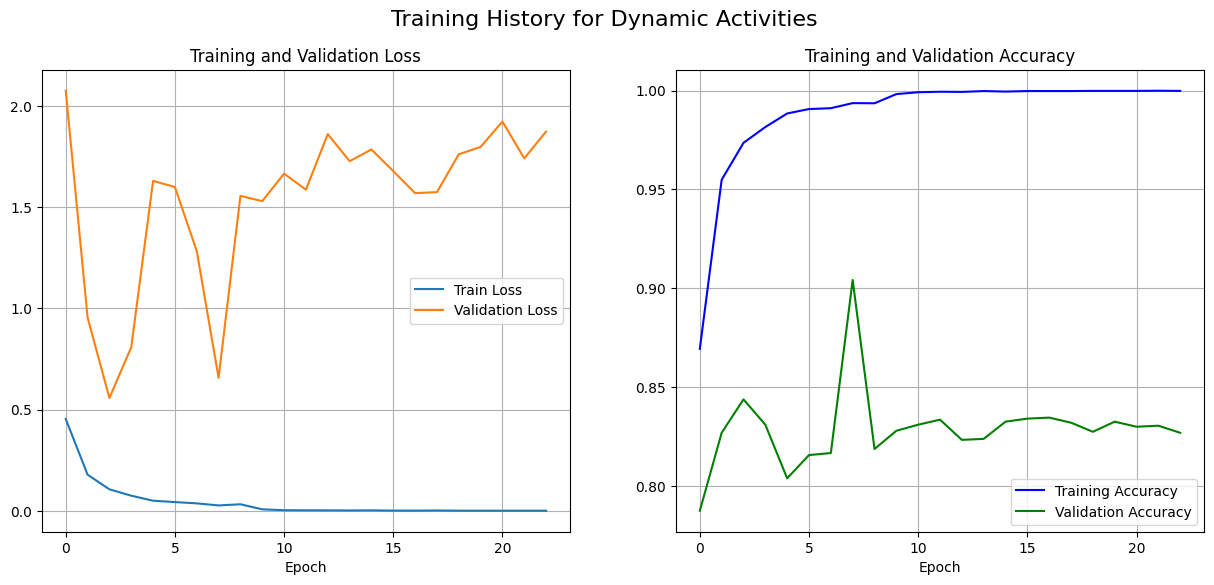



### STARTING EXPERIMENT FOR: STATIC ACTIVITIES ###
Filtered data for Static activities. Total rows: 108333

Creating datasets...
Dataset created with 1152 samples.
... Activity distribution: Counter({'Sitting': 646, 'Standing': 506})

Dataset created with 276 samples.
... Activity distribution: Counter({'Sitting': 140, 'Standing': 136})

Dataset created with 226 samples.
... Activity distribution: Counter({'Sitting': 135, 'Standing': 91})

Class Weights for Static: ['Sitting' 'Standing']
Calculated weights: [0.89164084 1.1383399 ]
Model for Static created with 2 output classes.

--- Model Summary ---
Layer (type:depth-idx)                             Output Shape              Param #
ResNet1D_CBAM                                      [64, 2]                   --
├─Sequential: 1-1                                  [64, 64, 32]              --
│    └─Conv1d: 2-1                                 [64, 64, 64]              1,344
│    └─BatchNorm1d: 2-2                            [64, 64, 64

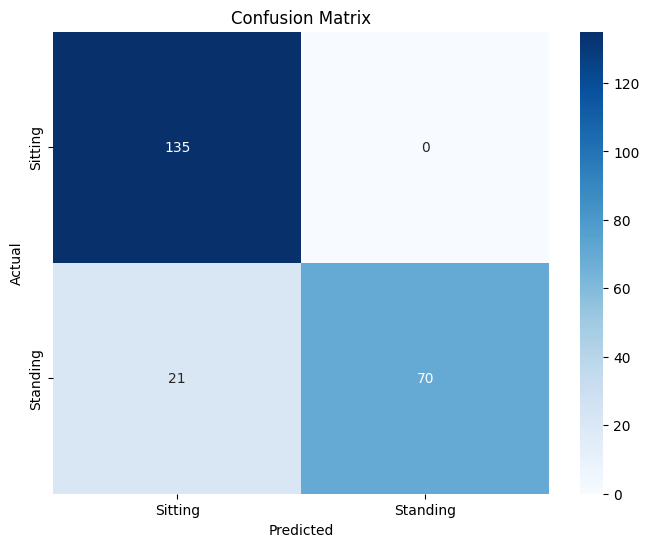

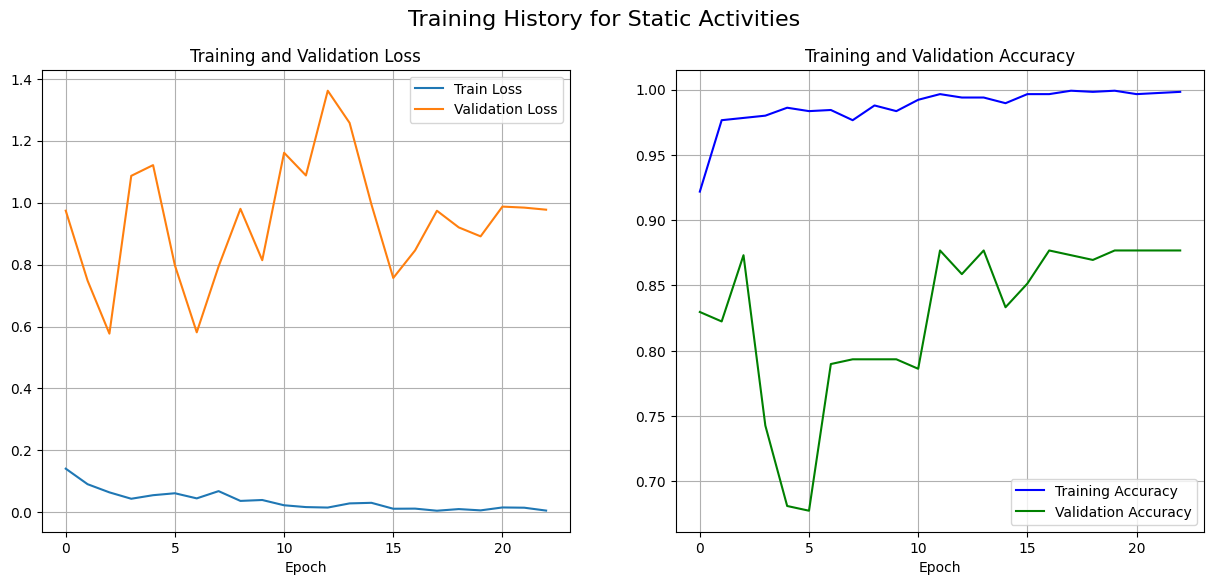

In [16]:
def run_experiment(activity_type, activities, full_df, num_epochs=30):
    print("="*60)
    print(f"### STARTING EXPERIMENT FOR: {activity_type.upper()} ACTIVITIES ###")
    print("="*60)

    # 1. 실험에 맞는 데이터만 필터링
    df = full_df[full_df['activity'].isin(activities)].copy()
    print(f"Filtered data for {activity_type} activities. Total rows: {len(df)}")

    # 2. 피험자 ID 기준으로 데이터프레임 분할
    train_df = df[df['user'] <= 28]
    val_df = df[(df['user'] > 28) & (df['user'] <= 32)]
    test_df = df[(df['user'] > 32) & (df['user'] <= 36)]

    # 3. 데이터셋 및 데이터로더 생성
    print("\nCreating datasets...")
    train_dataset = WISDMDataset(train_df, window_size=128)
    fitted_scaler = train_dataset.scaler
    val_dataset = WISDMDataset(val_df, window_size=128, scaler=fitted_scaler)
    test_dataset = WISDMDataset(test_df, window_size=128, scaler=fitted_scaler)

    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_dataset.encoded_labels),
        y=train_dataset.encoded_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    print(f"Class Weights for {activity_type}: {train_dataset.activity_encoder.classes_}")
    print(f"Calculated weights: {class_weights.cpu().numpy()}")
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 4. 모델 생성
    num_classes = len(activities)
    model = ResNet1D_CBAM(BasicBlock1D_CBAM, [3, 4, 6, 3], num_classes, input_channels=3)
    print(f"Model for {activity_type} created with {num_classes} output classes.")

    print("\n--- Model Summary ---")
    print(summary(model, input_size=(64, 3, 128))) # (batch_size, channels, sequence_length)
    print("---------------------\n")

    # 5. 모델 훈련
    print(f"--- Training {activity_type} Model ---")
    model_save_path = f'best_model_{activity_type.lower()}.pth'
    history = train_model(model, train_loader, val_loader, num_epochs, model_save_path, class_weights, patience=20)

    # 6. 최종 평가 및 시각화
    print(f"\n--- Final Evaluation for {activity_type} Model ---")
    model.load_state_dict(torch.load(model_save_path))
    evaluate_model(model, test_loader, test_dataset)
    plot_training_history(history, f'Training History for {activity_type} Activities')
    print("\n")

if __name__ == '__main__':
    file_path = '/content/drive/MyDrive/AI_data/WISDM_HAR.csv'
    full_data = load_and_preprocess_data(file_path)

    # dynamic activities
    dynamic_activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
    run_experiment('Dynamic', dynamic_activities, full_data, num_epochs=100)

    # static activities
    static_activities = ['Sitting', 'Standing']
    run_experiment('Static', static_activities, full_data, num_epochs=100)